<a id = '0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color:#FFCE30 ; color : #36609A; border-radius: 5px 5px; padding:3px;text-align:center; font-weight: bold" >Table of Contents</h2> 


*  [1. Introduction](#1.0)
*  [2. Initial Ground Work](#2.0)
*  [3. Data visualization](#3.0)
*  [4. Classification with Vanila CNN](#4.0)
*  [5. Data agumentaion, learning rate schedule, and Early stoping](#5.0)
*  [6. Classification with ResNet](#6.0)
*  [7. Final predictions on Test Set](#7.0)
*  [8. Summary](#8.0)


<a id = '1.0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color:#FFCE30 ; color : #36609A; border-radius: 5px 5px; padding:3px;text-align:center; font-weight: bold" >1. Introduction</h2> 

<a id = '2.0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color:#FFCE30 ; color : #36609A; border-radius: 5px 5px; padding:3px;text-align:center; font-weight: bold" >2. Initial Ground Work</h2> 


<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >loading all the required libraries.....</p>

In [1]:
class color:
    BOLD = '\033[1m'
    BOLD_COLOR = '\033[1m' + '\033[93m'
    END = '\033[0m'



# loading libraries
print(color.BOLD + '\nImporting requreid libraries....\n'+ color.END)

import warnings 
warnings.filterwarnings('ignore')

# basic librareis
import zipfile
import glob
import os
import pandas as pd
import numpy as np
from PIL import Image


# plotting and visualizations
import matplotlib 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import missingno as msno

# preprocessing
from keras.preprocessing.image import (ImageDataGenerator, 
                                       img_to_array, 
                                       array_to_img, 
                                       load_img)

from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             accuracy_score, 
                             f1_score, 
                             roc_auc_score)
# modeling
import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten

from keras.applications import resnet50
from keras.applications.resnet50 import preprocess_input
from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping,LearningRateScheduler


from keras import backend as K
K.clear_session()

# model plotting
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# mesc
from sklearn.utils import shuffle





print(color.BOLD_COLOR + 'Done!!!'+ color.END)



Importing requreid libraries....

Done!!!



<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >Color paleete for this notebook...</p>

<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >Lets Extract Labels from Image Names...</p>

In [3]:
# extraction of train and test data from zipfiles to data folder
print('\n'+color.BOLD_COLOR + 'Extracting the data from dataset.....'+ color.END +'\n')
zip_files = glob.glob('/kaggle/input/dogs-vs-cats/*.zip')

print('{} files found in the input directory'.format(color.BOLD + str(len(zip_files)) + color.END) +'\n')
for file in zip_files:
    with zipfile.ZipFile(file, 'r') as Z:
        Z.extractall('data')
    print ('{} is extracted'.format(color.BOLD + file.split('/')[-1] + color.END) + '\n')
      
print( color.BOLD_COLOR +'Extraction is completed'+ color.END +'\n')
    
  


Extracting the data from dataset.....

2 files found in the input directory

test1.zip is extracted

train.zip is extracted

Extraction is completed



In [4]:
# Total number of images in train and test datasets

train_dir = '/kaggle/working/data/train/'
test_dir  = '/kaggle/working/data/test1/'
print(color.BOLD +"Total Images in Train, and Test Data..." +color.END)
print('\n' + color.BOLD_COLOR + 'No. of Train Images: '+ color.END + color.BOLD + str(len(os.listdir(train_dir))) + color.END)
print( color.BOLD_COLOR + 'No. of Test Images: ' + color.END + color.BOLD + str(len(os.listdir(test_dir))) + color.END + '\n')        

Total Images in Train, and Test Data...

No. of Train Images: 25000
No. of Test Images: 12500



In [5]:
# category and filepath extraction helper functions

def category(path): 
    return [file.split('.')[0] for file in os.listdir(path)]

def filename(path):
    return [file for file in os.listdir(path)]

# image names and labels
x_train_imgname = filename(train_dir) 
x_test_imgname = filename(test_dir)
y_train_label = category(train_dir)

#creation of total dataframe and submission dataframe
print( '\n'+color.BOLD + 'Image data is storing into dataframes...'+ color.END + '\n')
train_image_df = pd.DataFrame({ 'filename': x_train_imgname, 'category': y_train_label})
submission_image_df = pd.DataFrame({'filename': x_test_imgname})

print(color.BOLD +'Training image names and labels are read to '+ color.END + color.BOLD_COLOR +'train_image_df' + color.END + '\n')
print(color.BOLD +'Testing image names are read to '+ color.END + color.BOLD_COLOR + 'submission_image_df'+ color.END + '\n')




Image data is storing into dataframes...

Training image names and labels are read to train_image_df

Testing image names are read to submission_image_df



<a id = '3.0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color:#FFCE30 ; color : #36609A; border-radius: 5px 5px; padding:3px;text-align:center; font-weight: bold" >3.Data visualization</h2> 

<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >Lets write helper funtions for path extraction and visualization of training images...</p>

In [6]:
print(color.BOLD +'\n'+'Helper funtions for image path,id, category data extractions and Image visualizations' +'\n'+color.END)
# helper functions 

def img_path(directory):
    ''' 
    This function extracts image ids, category,and image paths from directory.
    input:
    directiory: Path to location of images
    Return:
    ID_no: list of image ids
    Paths: list of image paths
    cate: list of category
    '''
    paths = []
    cate = []
    ID_no = []
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        paths.append(path)
        cate.append(file.split('.')[0])
        ID_no.append(file.split('.')[1])
    return ID_no, paths, cate




def showImages(data,num_row  = 3,num_col =  3, name = 'any', subtitle = 'off'):
    """ This function creates a grid of images from  dataset.
    Shuffled images will be displayed.
    
    Input: 
    num_row: default: 3, no. of rows in a grid
    num_col: default:3, no. of columns in grid
    data: Dataframe of paths 
    name:  default 'any', takes: cat, dog, any or something else would give both
    subtitle: display id number for each image, defalult: 'off', takes: 'on' and 'off'
    Return: None
    
    """
    
    # little data sorting
    cat_df,dog_df = data[data['Category'] == 'cat'], data[data['Category'] == 'dog']

    
    if name == 'dog':
        X, Y  = dog_df['img_paths'], dog_df['ID_no']
    elif name == 'cat':
        X, Y  = cat_df['img_paths'], cat_df['ID_no']     
    else:
        X, Y  = data['img_paths'], data['ID_no']     # could use try and except but lets stick to minimal code

    (X_rand, Y_rand) = shuffle(X, Y)
    
    # showing images on matplotlib 
    
    fig, ax = plt.subplots(num_row,num_col,figsize = (12,12), dpi = 100)
    fig.patch.set_facecolor('#f5f6f6')
    axes = ax.ravel()
    
    for idx,ax  in enumerate(axes):
        x = load_img(X_rand.iloc[idx],target_size= (125, 125))
        ax.imshow(x)
        if subtitle == 'on':
            ax.set_title("{}".format(Y_rand.iloc[idx]))
        else:
            ax.set_title('')
        ax.axis('off')
        plt.subplots_adjust(wspace =0)
        del x
    #fig.tight_layout()
    
    fig.text(0.1,0.93, 'Hey Siri! is it a Cat or Dog?: {}s from Training Data'.format(name.capitalize()),{'fontfamily':'serif','size':18,'weight':'bold'})
    
    return None



Helper funtions for image path,id, category data extractions and Image visualizations



In [7]:
# Implementing above function over train data set
ID_no, img_paths, train_images = img_path(train_dir)

print('\n'+color.BOLD_COLOR + 'Dataframe is creating for training image visualization in a grid...' + color.END+'\n' )
#creating new dataframe for data visulaization

visual_df = pd.DataFrame({'ID_no':ID_no,'Category':train_images, 'img_paths': img_paths})

print(color.BOLD );print(visual_df.head(5))

print('\n'+color.BOLD_COLOR +'Done!'+color.END + '\n')


Dataframe is creating for training image visualization in a grid...


   ID_no Category                                 img_paths
0   8645      cat   /kaggle/working/data/train/cat.8645.jpg
1   6968      cat   /kaggle/working/data/train/cat.6968.jpg
2   2172      dog   /kaggle/working/data/train/dog.2172.jpg
3  10325      cat  /kaggle/working/data/train/cat.10325.jpg
4   8008      dog   /kaggle/working/data/train/dog.8008.jpg

Done!



<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >Lets see the images from training images...</p>

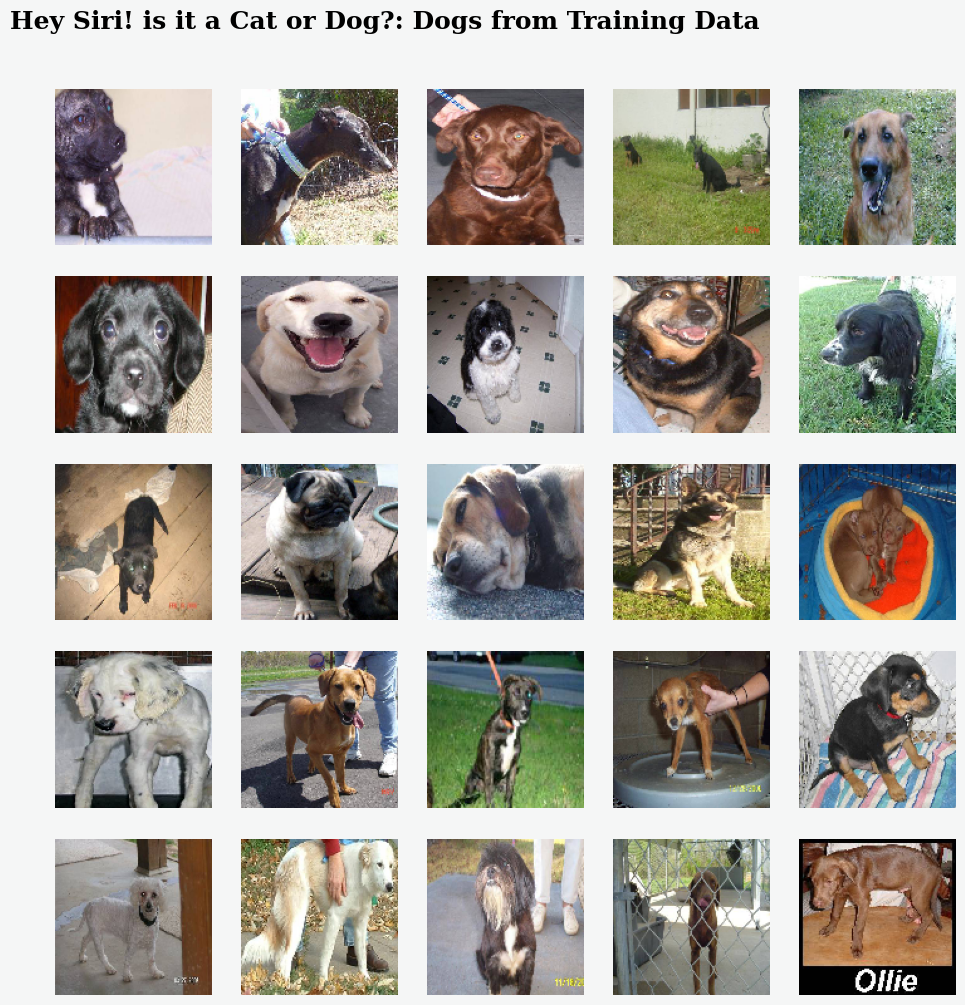

In [8]:
showImages(visual_df,5,5, name = 'dog', subtitle = 'off')

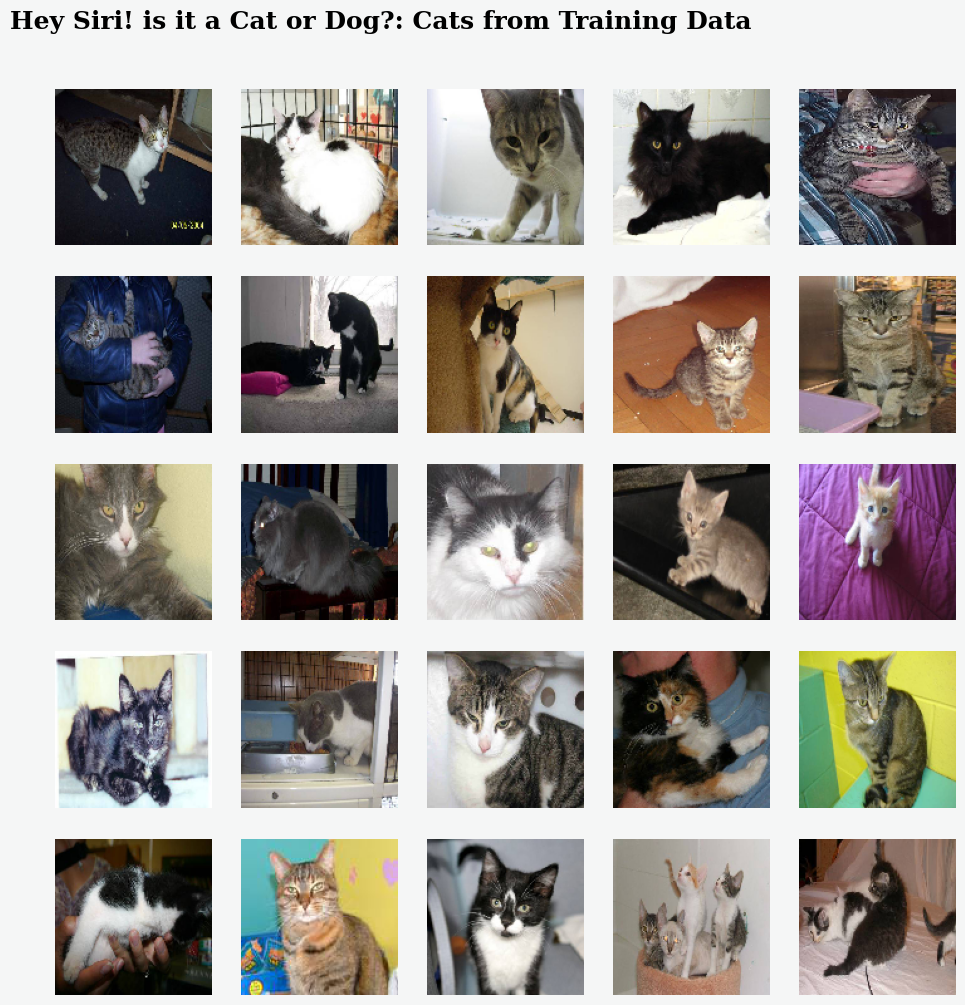

In [9]:
showImages(visual_df,5,5, name = 'cat', subtitle = 'off')

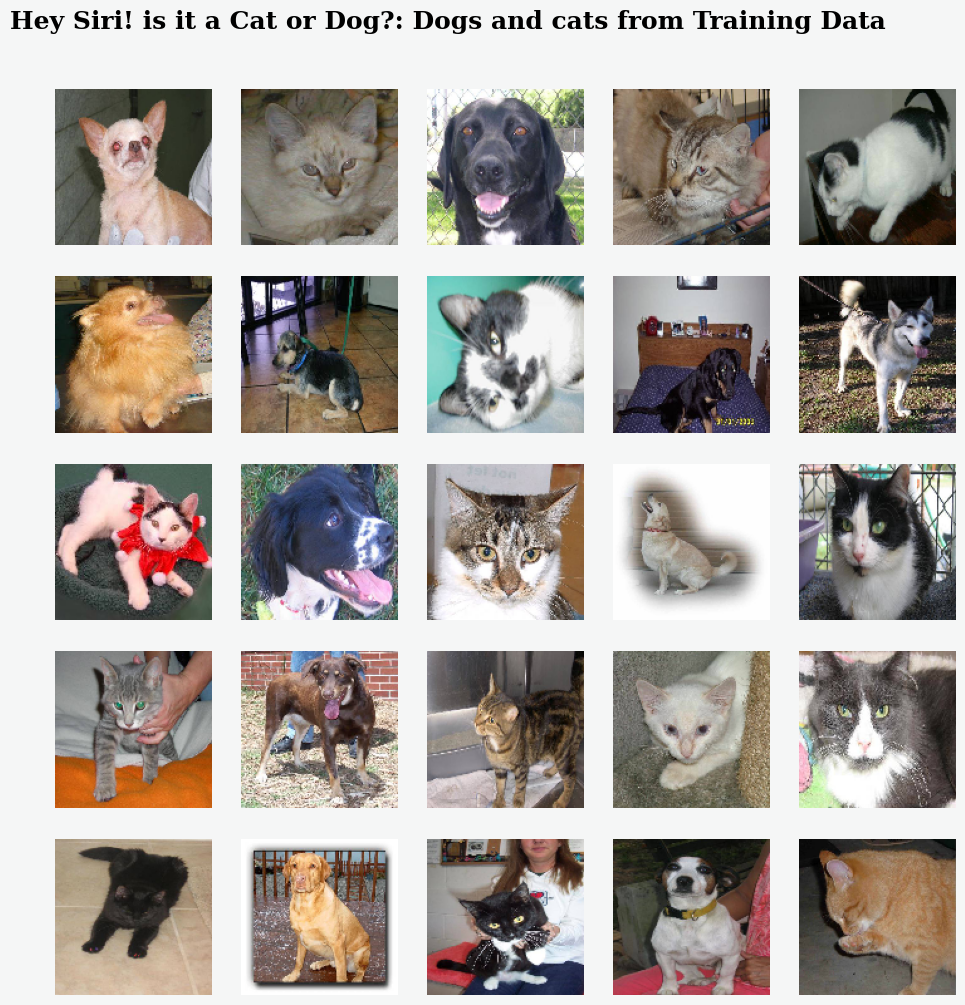

In [10]:
showImages(visual_df,5,5, name = 'Dogs and Cat', subtitle = 'off')

<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >Lets split data into training and validation dataset, and visualize the data distribution...</p>

In [11]:
# Data split into train data and validation data
train_valid_df, test_df = train_test_split(train_image_df, test_size = 0.04)
train_df, valid_df = train_test_split(train_valid_df, test_size = 0.2)

train_images = train_df.shape[0]
valid_images = valid_df.shape[0]
holdon_images = test_df.shape[0]
test_images = submission_image_df.shape[0]

print('\n'+color.BOLD_COLOR + 'Number of Training Images: ' + color.END + color.BOLD+ str(train_images)+ color.END)
print('\n'+color.BOLD_COLOR +  'Number of Validating Images: ' + color.END + color.BOLD+ str(valid_images)+ color.END)
print( '\n'+color.BOLD_COLOR +  'Number of Holdon Images: ' + color.END +  color.BOLD+ str(holdon_images)+ color.END)
print('\n'+color.BOLD_COLOR + 'Number of Testing Images: ' + color.END +  color.BOLD+str(test_images)+ color.END)



Number of Training Images: 19200

Number of Validating Images: 4800

Number of Holdon Images: 1000

Number of Testing Images: 12500


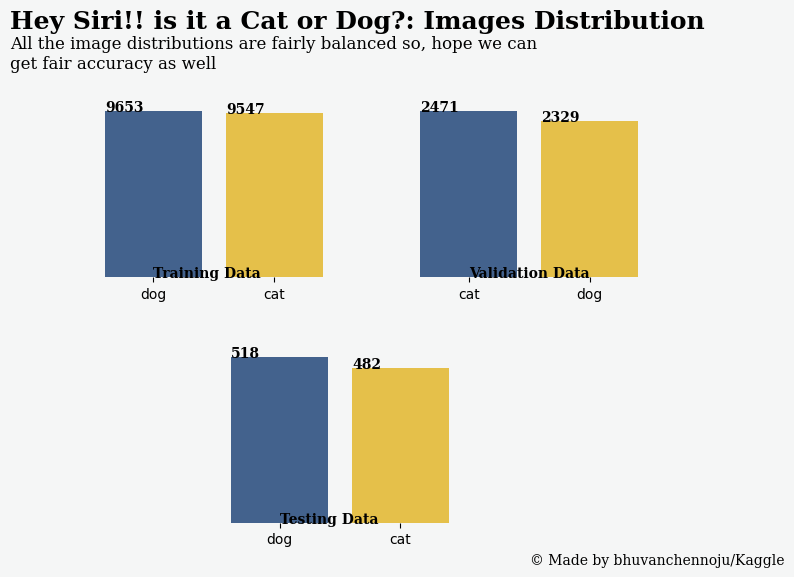

In [12]:
fig = plt.figure(figsize =(8,8), dpi = 100)
fig.patch.set_facecolor('#f5f6f6')
gs = fig.add_gridspec(10,10)

ax0 = fig.add_subplot(gs[2:5,1:5])
ax1 = fig.add_subplot(gs[2:5,6:10])
ax2 = fig.add_subplot(gs[6:9,3:7])


axes = [ax0,ax1,ax2]
data  = [train_df['category'] ,  valid_df['category'], test_df['category']]
labels = ['Training Data','Validation Data','Testing Data']

for ax in axes:
    ax.set_facecolor('#f5f6f6')
    ax.axes.get_yaxis().set_visible(False)
    
    for loc in ['left','right','top','bottom']:
        ax.spines[loc].set_visible(False)
    
for ax,df, label in zip(axes,data,labels):
    sns.countplot(df, ax = ax, palette = [colors[2],colors[3]], alpha =1)
    ax.set_xlabel(xlabel = ' ')
    for pa in ax.patches: 
        ax.text(pa.get_x(), pa.get_height(),'{}'.format(pa.get_height()), **{'fontfamily':'serif', 'size':10, 'weight':'bold'}, alpha = 1)

    ax.text(0,0,label,**{'fontfamily':'serif', 'size':10, 'weight':'bold'})

fig.text(0.1,0.82, 'Hey Siri!! is it a Cat or Dog?: Images Distribution',{'fontfamily':'serif','size':18,'weight':'bold'})
fig.text(0.1,0.77, '''All the image distributions are fairly balanced so, hope we can
get fair accuracy as well''',{'fontfamily':'serif','size':12,})

fig.text(0.75,0.15,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
fig.show()

<a id = '4.0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color:#FFCE30 ; color : #36609A; border-radius: 5px 5px; padding:3px;text-align:center; font-weight: bold" >4. Classification with Vanilla CNN</h2> 

Our datasets are evenly distributed. In this notebook, for the first benchmark model I will use a pretrained model and it can further improved upon. 
Since, our task is similar to ImageNet challenge with 2 class classification any pretrained model from [keras applcations](https://keras.io/api/applications/) can be used.
Moreover, it's is not that practical to achieve a higher accurarcy with a custom build cnn from scartch. 

let's get started with a simple vanila network without data augmentation (shown in figure below) first to see how good it can perform. Later, we will move towards other techniques.



<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" > Let prepared training, validation, testing data for vanilla CNN without any agumentations...</p>

In [13]:
img_size = 224
batch_size = 128

print(color.BOLD_COLOR + '\nPreparing train and validation images for training...' + color.END)
# dataframe iterators without data agumnetation

train_map = ImageDataGenerator()
valid_map = ImageDataGenerator()
test_map =  ImageDataGenerator()

print(color.BOLD)
        
#Creatinga a dataframe iterators for fitting
vani_train_data = train_map.flow_from_dataframe(
            train_df,train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = (img_size, img_size),
            batch_size = batch_size,
            class_mode = 'categorical')

vani_valid_data = valid_map.flow_from_dataframe(
             valid_df, train_dir,
             x_col = 'filename',
             y_col = 'category',
             target_size = (img_size, img_size),
             batch_size = batch_size,
             class_mode = 'categorical')


vani_test_data = test_map.flow_from_dataframe(
             test_df, train_dir,
             x_col = 'filename',
             y_col = None,
             target_size = (img_size, img_size),
             batch_size = batch_size,
             class_mode = None,
             shuffle = False)

print(color.BOLD_COLOR + '\nDone!')


Preparing train and validation images for training...

Found 19200 validated image filenames belonging to 2 classes.
Found 4800 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames.

Done!


<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >Lets build vanila CNN model ...</p>

In [14]:
#Building model computational graph
vani_model = Sequential()
vani_model.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same', input_shape = (224,224,3)))
vani_model.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

vani_model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

vani_model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

vani_model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

vani_model.add(Dropout(0.3))

vani_model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
vani_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

vani_model.add(Dropout(0.3))

vani_model.add(Flatten())

vani_model.add(Dense(512, activation = 'relu'))

vani_model.add(Dropout(0.5))

vani_model.add(Dense(2, activation = 'softmax'))

print(color.BOLD_COLOR + '\nVanilla Model layers and output shapes with params...\n'+color.END)

print(color.BOLD)
vani_model.summary()


Vanilla Model layers and output shapes with params...


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________

<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >Lets See vanila CNN model Schematic diagram ...</p>

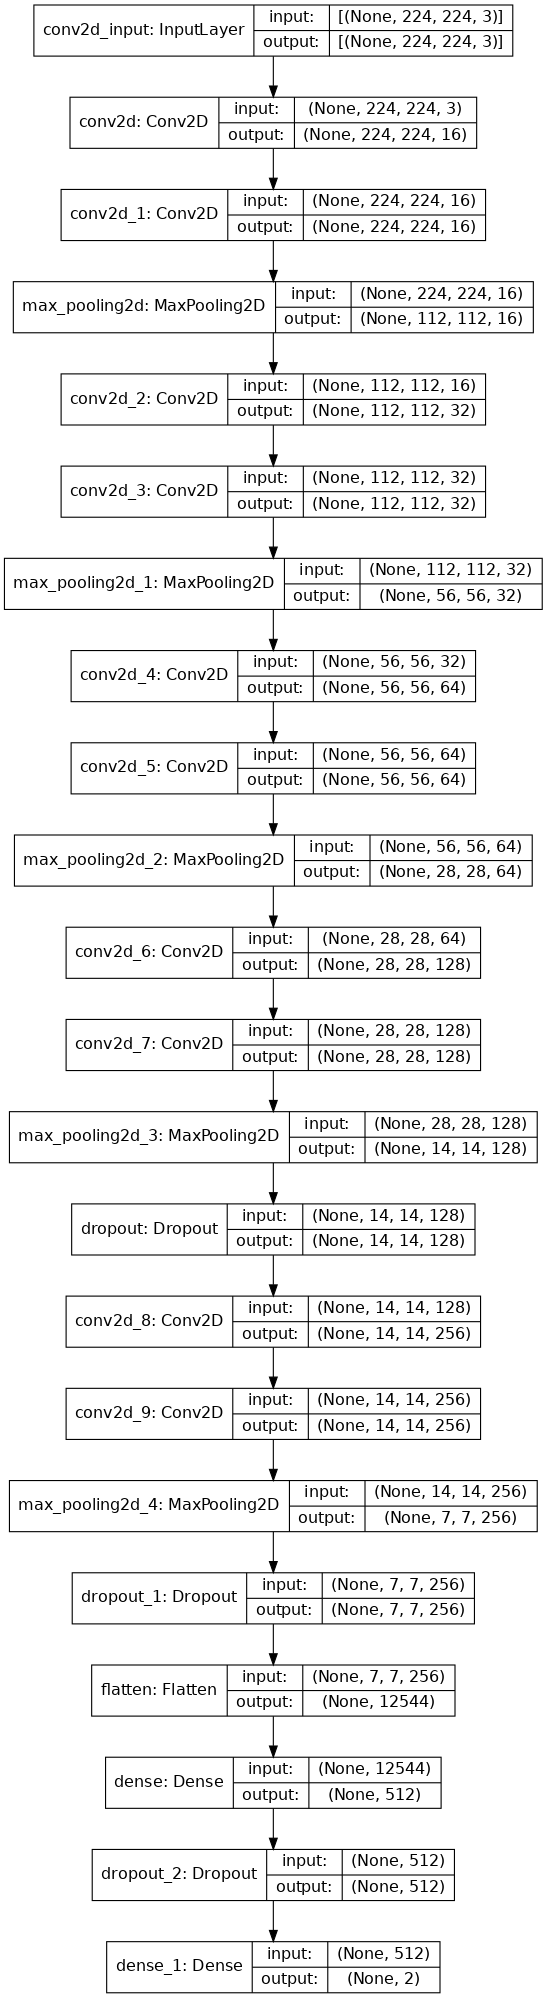

In [15]:
plot_model(vani_model, show_shapes = True,expand_nested = True,dpi = 80)
#SVG(model_to_dot(vani_model).create(prog='dot', format='svg'))

<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >Lets train and validate on vanila CNN model ...</p>

In [16]:
#compiling model with loss, opt, metrics
loss = 'categorical_crossentropy'
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001,beta_1=0.9, beta_2=0.999,epsilon=1e-07)
metrics = ['accuracy']

vani_model.compile(loss = loss, optimizer = opt, metrics = metrics)

print(color.BOLD_COLOR + 'Training on Vanilla CNN has started ....\n'+ color.END)
print(color.BOLD)
# fitting the model for training dataset
vani_history = vani_model.fit(vani_train_data, epochs = 15,
                          validation_data = vani_valid_data,
                          validation_steps= valid_images//batch_size,
                          steps_per_epoch= train_images//batch_size)

print(color.END)
print(color.BOLD_COLOR + '\nDone!\n'+ color.END)


Training on Vanilla CNN has started ....


Epoch 1/15
150/150 [==============================] - 174s 1s/step - loss: 1.0165 - accuracy: 0.5255 - val_loss: 0.6384 - val_accuracy: 0.6421
Epoch 2/15
150/150 [==============================] - 162s 1s/step - loss: 0.6185 - accuracy: 0.6471 - val_loss: 0.5585 - val_accuracy: 0.6989
Epoch 3/15
150/150 [==============================] - 161s 1s/step - loss: 0.5329 - accuracy: 0.7328 - val_loss: 0.4713 - val_accuracy: 0.7840
Epoch 4/15
150/150 [==============================] - 161s 1s/step - loss: 0.4718 - accuracy: 0.7783 - val_loss: 0.4512 - val_accuracy: 0.7927
Epoch 5/15
150/150 [==============================] - 162s 1s/step - loss: 0.4289 - accuracy: 0.8017 - val_loss: 0.4401 - val_accuracy: 0.7910
Epoch 6/15
150/150 [==============================] - 161s 1s/step - loss: 0.3916 - accuracy: 0.8231 - val_loss: 0.4101 - val_accuracy: 0.8129
Epoch 7/15
150/150 [==============================] - 161s 1s/step - loss: 0.3495 - accuracy: 0.845

<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >Lets plot vanila CNN model change in loss and accuracys with epochs ...</p>

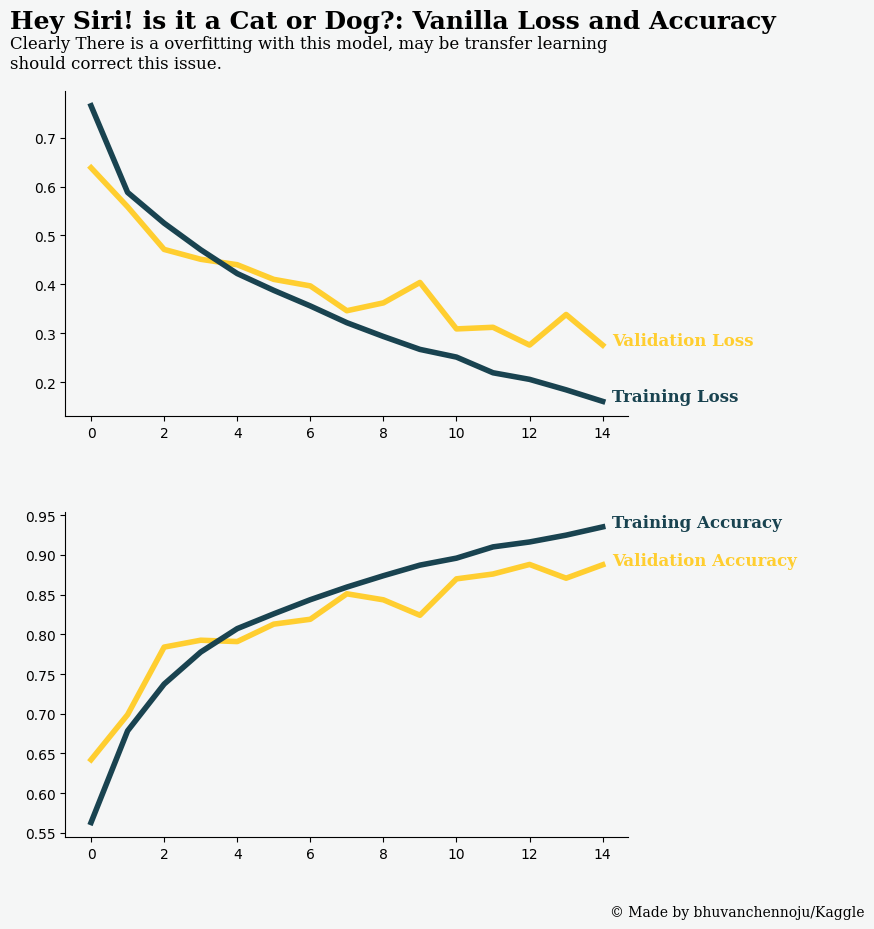

In [17]:
fig,ax  = plt.subplots(2,1, figsize =(8,8), dpi = 100)
fig.patch.set_facecolor('#f5f6f6')

axes  = ax.ravel()

for ax in axes:
    ax.set_facecolor('#f5f6f6')
    for loc in ['right','top',]:
        ax.spines[loc].set_visible(False)
        
hist1 = vani_history.history
Epochs =  range(len(hist1['loss']))

## loss plot
sns.lineplot(x = Epochs, y = hist1['val_loss'],  ax = axes[0], linewidth = 4, color = colors[3])
sns.lineplot(x = Epochs, y = hist1['loss'], ax  = axes[0], linewidth =4,  color = colors[4])


axes[0].text(Epochs[-1]+0.25,hist1['val_loss'][-1],'Validation Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[3]})
axes[0].text(Epochs[-1]+0.25,hist1['loss'][-1] ,'Training Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[4]})


# accuracy plot
sns.lineplot(x = Epochs, y = hist1['val_accuracy'],ax = axes[1],linewidth = 4, color = colors[3])
sns.lineplot(x = Epochs, y = hist1['accuracy'],ax = axes[1],linewidth =4,  color = colors[4])
axes[1].text(Epochs[-1]+0.25,hist1['val_accuracy'][-1],'Validation Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[3]})
axes[1].text(Epochs[-1]+0.25,hist1['accuracy'][-1] ,'Training Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[4]})


fig.text(0,1.06, 'Hey Siri! is it a Cat or Dog?: Vanilla Loss and Accuracy ',{'fontfamily':'serif', 'size':18, 'weight':'bold'})
fig.text(0,1.01, '''Clearly There is a overfitting with this model, may be transfer learning
should correct this issue.''',{'fontfamily':'serif', 'size':12})
        
fig.text(0.75,-0.05,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
plt.tight_layout(h_pad = 5)

<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >Lets see vanila CNN predictions with confusion matrix ...</p>

In [18]:
vani_pred = vani_model.predict_generator(vani_test_data)
test_df['vani_pred'] = np.argmax(vani_pred, axis = -1)
labels = dict((v,k) for k,v in vani_train_data.class_indices.items())

test_df['vani_pred'] = test_df['vani_pred'].map(labels)


In [19]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor('#f5f6f6')
    sns.heatmap(cf,annot=box_labels,fmt="",linewidths = 1,square = True,linecolor= '#f5f6f6',
                cmap=cmap,cbar=cbar,annot_kws={'fontfamily':'serif','size':18,'weight':'bold'},
                xticklabels=categories,
                yticklabels=categories,)

    if xyplotlabels:
        plt.ylabel('True label', **{'fontfamily':'serif','size':12,'weight':'bold'})
        plt.xlabel('Predicted label' + stats_text,**{'fontfamily':'serif','size':12,'weight':'bold'})
    else:
        plt.xlabel(stats_text,**{'fontfamily':'serif','size':12,'weight':'bold'})
    
    plt.gca().set_xticklabels(categories, {'fontfamily':'serif','size':16,'weight':'bold'})
    plt.gca().set_yticklabels(categories, {'fontfamily':'serif','size':16,'weight':'bold'})

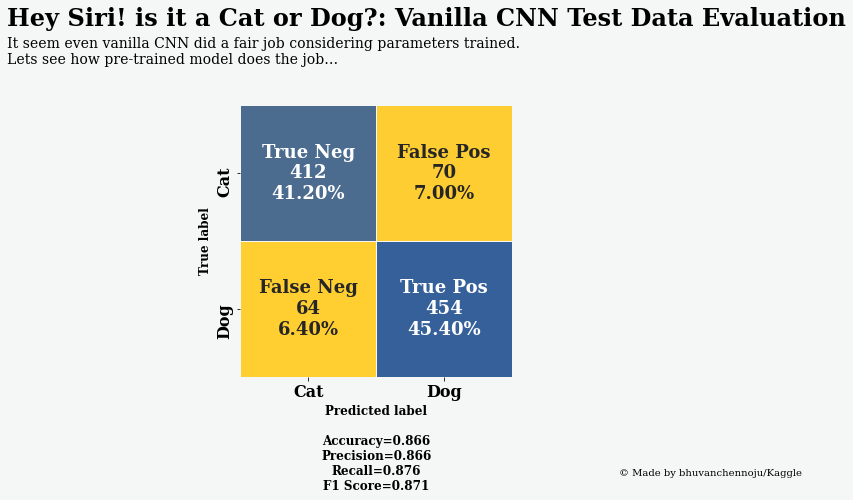

In [20]:
vani_cf_matrix = confusion_matrix(test_df['category'],test_df['vani_pred'])
my_cols = [colors[3],colors[2]]

labels = [ 'True Neg','False Pos','False Neg','True Pos']
categories = ['Cat', 'Dog']
make_confusion_matrix(vani_cf_matrix,figsize = (10,5),
                      group_names=labels,cbar = False,cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",my_cols),
                      categories=categories, 
                      title = 'Vanila CNN comfusion matrix')

plt.gcf().text(0,1.1,'Hey Siri! is it a Cat or Dog?: Vanilla CNN Test Data Evaluation',{'fontfamily':'serif', 'size':24,  'color':'black', 'weight':'bold'})
plt.gcf().text(0,0.995,"""It seem even vanilla CNN did a fair job considering parameters trained.
Lets see how pre-trained model does the job...""",{'fontfamily':'serif', 'size':14,  'color':'black', })

plt.gcf().text(0.85,-0.15,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
plt.gcf().show()


<a id = '5.0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color:#FFCE30 ; color : #36609A; border-radius: 5px 5px; padding:3px;text-align:center; font-weight: bold" >5. Data Agumentation, Early Stopping, Learning Rate Schedule</h2> 

<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" > Lets code helper function for visualization of image agumentation...</p>

In [21]:
print(color.BOLD +'\n'+'Helper funtions for Image Agumentation visualizations' +'\n'+color.END)

def data_argumentation_show(n, grid_size):
    sample_aug_map = ImageDataGenerator(
            #zoom_range = 0.1,
            rotation_range = 25,
            horizontal_flip = True,
            height_shift_range =0.2,
            width_shift_range = 0.2,
            fill_mode='nearest',
            rescale = 1/255)
    sample_data = sample_aug_map.flow_from_dataframe(
            (train_df.sample(n)),
            train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = (img_size, img_size),
            class_mode = 'categorical')
  
  #subplot grid 
    fig = plt.figure(figsize = (10,10))
    fig.patch.set_facecolor('#f5f6f6')
    for i in range(0,grid_size*grid_size):
        plt.subplot(grid_size,grid_size, i+1)
        for x,y in sample_data:
            img = x[0]
            plt.imshow(img)
            plt.axis('off')
            break
            plt.tight_layout()
            del img
    fig.show()

     
    fig.text(0.1,0.93, 'Hey Siri! is it cat or dog?: Image agumentation',{'fontfamily':'serif','size':20,'weight':'bold'})
    
    return None




Helper funtions for Image Agumentation visualizations



Found 1 validated image filenames belonging to 1 classes.


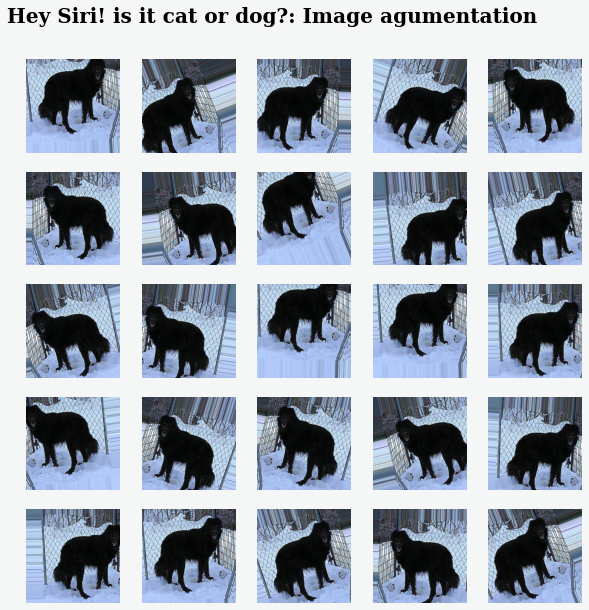

In [22]:
# To visulalize the effect of data argumentation 
#select number of samples to argument----> n = 
# total number of argumentation is grid_Size**2

data_argumentation_show(1, 5)

Found 2 validated image filenames belonging to 2 classes.


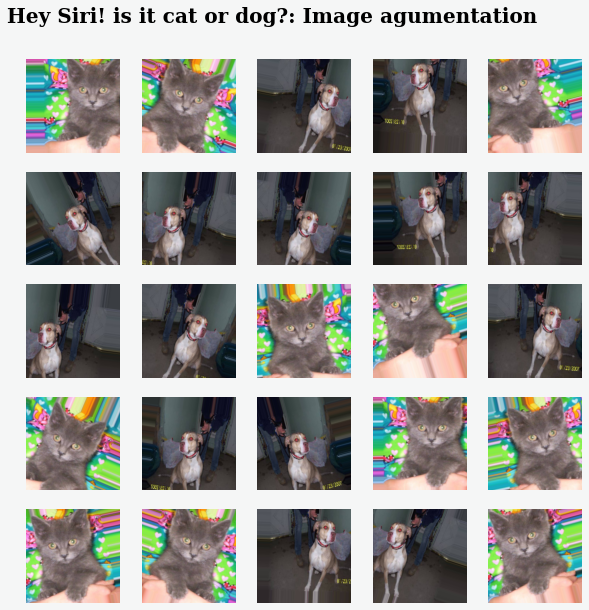

In [23]:
data_argumentation_show(2, 5)

<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" > Decaying learing rate setting function...</p>

In [24]:
print(color.BOLD + '\nSetting a decay learning rate for learning rate schedule\n'+ color.END)
epoch = 50
learning_rate = 3e-5 
lr_start = 0.00000001
lr_min = 0.000001
lr_max = 3e-5 
lr_rampup_epochs = 1
lr_sustain_epochs = 1
lr_exp_decay = .8

def lrfn(epoch):
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
    return lr
    
print(color.BOLD_COLOR + 'Done!' +color.END)



Setting a decay learning rate for learning rate schedule

Done!


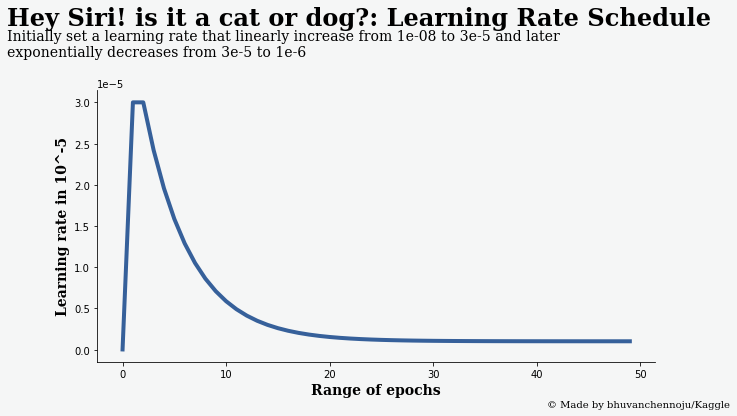

In [25]:
epochs = 20
epochs_range = [i for i in range(50 if epochs<50 else epochs)]
learn_rate = [lrfn(x) for x in epochs_range]


fig,ax = plt.subplots(figsize = (10,5))
fig.patch.set_facecolor('#f5f6f6')
ax.set_facecolor('#f5f6f6')

for loc in ['right','top',]:
    ax.spines[loc].set_visible(False)

ax.plot(epochs_range, learn_rate, linewidth = 4, color= colors[2]) 
plt.xlabel('Range of epochs',{'fontfamily':'serif', 'size':14,  'color':'black', 'weight':'bold'})
plt.ylabel('Learning rate in 10^-5',{'fontfamily':'serif', 'size':14,  'color':'black', 'weight':'bold'})


plt.gcf().text(0,1.06,'Hey Siri! is it a cat or dog?: Learning Rate Schedule',{'fontfamily':'serif', 'size':24,  'color':'black', 'weight':'bold'})
plt.gcf().text(0,0.975,"""Initially set a learning rate that linearly increase from 1e-08 to 3e-5 and later
exponentially decreases from 3e-5 to 1e-6""",{'fontfamily':'serif', 'size':14,  'color':'black', })

plt.gcf().text(0.75,0,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
plt.gcf().show()

<a id = '6.0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color:#FFCE30 ; color : #36609A; border-radius: 5px 5px; padding:3px;text-align:center; font-weight: bold" >6. Classification with ResNet50</h2> 

<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" > Image agumentation data preparation with ImageDataGenerator</p>

In [26]:
print(color.BOLD_COLOR + '\n Agumenting Train, Validation images... and testing images just passing through... \n'+ color.END)

print(color.BOLD)
# using standard data augumentation

train_aug_map = ImageDataGenerator(
                    rotation_range=10,
                    #zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    #width_shift_range=0.1,
                    #height_shift_range=0.1,
                    preprocessing_function = preprocess_input)
res_train_data = train_aug_map.flow_from_dataframe(
            train_df, train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = (img_size, img_size),
            batch_size = batch_size,
            class_mode = 'categorical')

#one should validate the generality of model on the actcual target images
#so not supposed agumentation
valid_aug_map = ImageDataGenerator(preprocessing_function = preprocess_input)

res_valid_data = valid_aug_map.flow_from_dataframe(
             valid_df, train_dir,
             x_col = 'filename',
             y_col = 'category',
             target_size = (img_size, img_size),
             batch_size = batch_size,
             class_mode = 'categorical')


#test data rescaling images

test_aug_map = ImageDataGenerator(preprocessing_function = preprocess_input)

res_test_data = test_aug_map.flow_from_dataframe(
             test_df, train_dir,
             x_col = 'filename',
             y_col = None,
             class_mode = None,
             target_size = (img_size, img_size),
             shuffle = False)
           



 Agumenting Train, Validation images... and testing images just passing through... 


Found 19200 validated image filenames belonging to 2 classes.
Found 4800 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames.


<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" > Building model for transfer learning on top of pretrained ResNet50 Model...</p>

In [27]:
#loading resent 
resNet = tf.keras.applications.ResNet50(weights = 'imagenet',
                        include_top = False,
                        input_shape = (224,224, 3))

resNet.trainable = False # Freeze layers
resNet_model = Sequential([
        resNet,
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dropout(0.4),
        Dense(2, activation = 'softmax')])
     

optimizer = optimizers.Adam(1e-5)

print(color.BOLD_COLOR + '\nResNet based Transfer learning Model layers and output shapes with params...\n'+color.END)

print(color.BOLD)
resNet_model.summary()
#plot_model(resNet_model, to_file='resNet_model.png')

94773248/94765736 [==============================] - 0s 0us/step

ResNet based Transfer learning Model layers and output shapes with params...


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 126,351,234
Trainable params: 102,763,522
Non-trainable params: 23,587,712
__________________

In [28]:
print(color.BOLD + '\nSetting early stopping factor and learning rate schedule\n' +color.END)

earlystop = EarlyStopping(patience= 5)
    
lr_callback = LearningRateScheduler(lrfn, verbose = True)

callbacks = [earlystop, lr_callback]
print(color.BOLD_COLOR + 'Done!')


Setting early stopping factor and learning rate schedule

Done!


<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >Lets train and validate Pre-trained ResNet50 model for top layers...</p>

In [29]:
resNet_model.compile(optimizer = optimizer,
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

print(color.BOLD_COLOR + 'Training on ResNet50 has started ....\n'+ color.END)
print(color.BOLD)

resnet_history = resNet_model.fit_generator(res_train_data, epochs = 15,
                          validation_data = res_valid_data,
                          validation_steps= valid_images//batch_size,
                          steps_per_epoch= train_images//batch_size,
                          callbacks = callbacks)
print(color.END)
print(color.BOLD_COLOR + 'Done!\n'+ color.END)

Training on ResNet50 has started ....


Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-08.
150/150 [==============================] - 287s 2s/step - loss: 1.8066 - accuracy: 0.5259 - val_loss: 1.2374 - val_accuracy: 0.5676
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3e-05.
150/150 [==============================] - 281s 2s/step - loss: 0.3917 - accuracy: 0.9379 - val_loss: 0.1066 - val_accuracy: 0.9835
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 3e-05.
150/150 [==============================] - 281s 2s/step - loss: 0.0490 - accuracy: 0.9910 - val_loss: 0.0754 - val_accuracy: 0.9854
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.4200000000000002e-05.
150/150 [==============================] - 280s 2s/step - loss: 0.0235 - accuracy: 0.9933 - val_loss: 0.0603 - val_accuracy: 0.9856
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 1.9560000000000006e-05

<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >Lets plot Resnet models change in loss and accuracys with epochs ...</p>

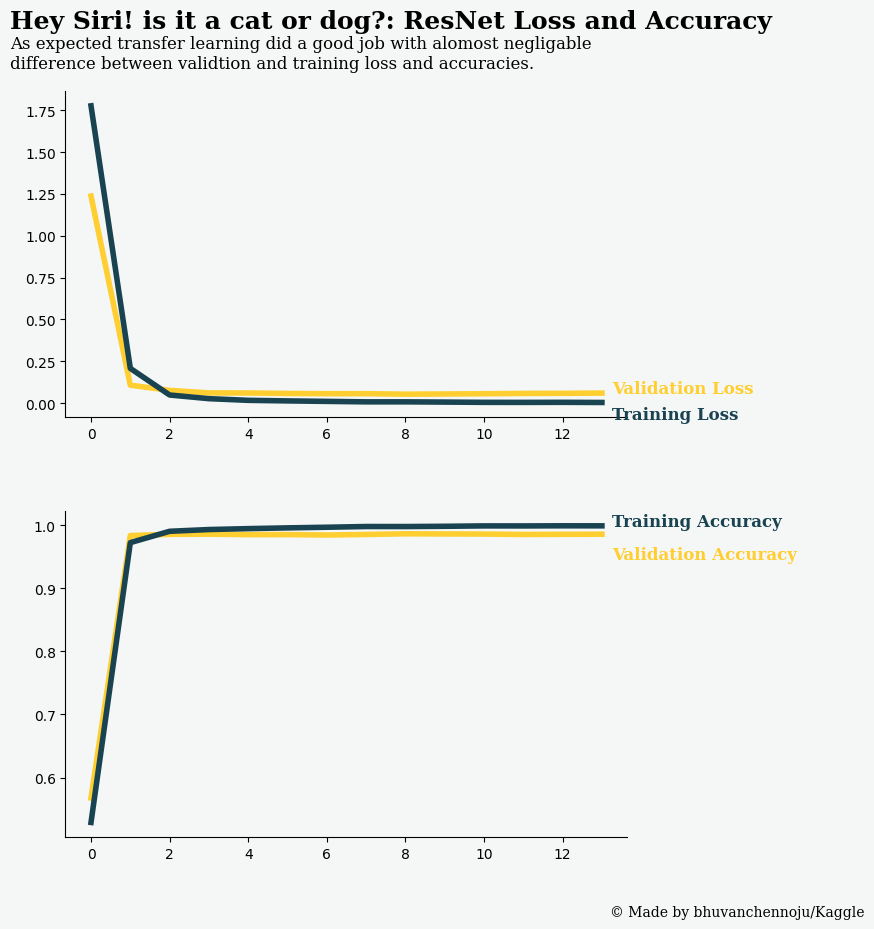

In [30]:
fig,ax  = plt.subplots(2,1, figsize =(8,8), dpi = 100)
fig.patch.set_facecolor('#f5f6f6')

axes  = ax.ravel()

for ax in axes:
    ax.set_facecolor('#f5f6f6')
    for loc in ['right','top',]:
        ax.spines[loc].set_visible(False)
        
hist2 = resnet_history.history
Epochs =  range(len(hist2['loss']))

## loss plot
sns.lineplot(x = Epochs, y = hist2['val_loss'],  ax = axes[0], linewidth = 4, color = colors[3])
sns.lineplot(x = Epochs, y = hist2['loss'], ax  = axes[0], linewidth =4,  color = colors[4])


axes[0].text(Epochs[-1]+0.25,hist2['val_loss'][-1],'Validation Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[3]})
axes[0].text(Epochs[-1]+0.25,hist2['loss'][-1]-0.1 ,'Training Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[4]})


# accuracy plot
sns.lineplot(x = Epochs, y = hist2['val_accuracy'],ax = axes[1],linewidth = 4, color = colors[3])
sns.lineplot(x = Epochs, y = hist2['accuracy'],ax = axes[1],linewidth =4,  color = colors[4])
axes[1].text(Epochs[-1]+0.25,hist2['val_accuracy'][-1]-0.04,'Validation Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[3]})
axes[1].text(Epochs[-1]+0.25,hist2['accuracy'][-1] ,'Training Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold','color':colors[4]})


fig.text(0,1.06, 'Hey Siri! is it a cat or dog?: ResNet Loss and Accuracy ',{'fontfamily':'serif', 'size':18, 'weight':'bold'})
fig.text(0,1.01, '''As expected transfer learning did a good job with alomost negligable
difference between validtion and training loss and accuracies.''',{'fontfamily':'serif', 'size':12})
fig.text(0.75,-0.05,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
        
plt.tight_layout(h_pad = 5)

fig.show()

<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >Lets see ResNet predictions with confusion matrix ...</p>

In [31]:
res_pred = resNet_model.predict_generator(res_test_data)
test_df['res_pred'] = np.argmax(res_pred, axis = -1)
labels = dict((v,k) for k,v in res_train_data.class_indices.items())

test_df['res_pred'] = test_df['res_pred'].map(labels)


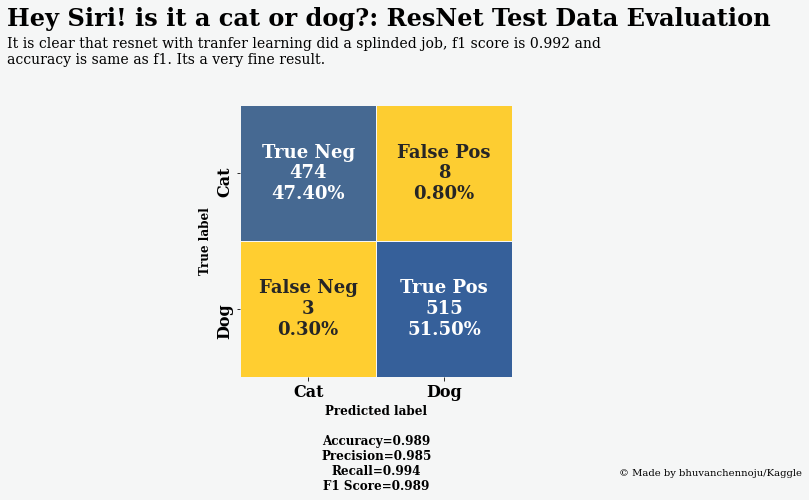

In [32]:
res_cf_matrix = confusion_matrix(test_df['category'],test_df['res_pred'])
my_cols = [colors[3],colors[2]]

labels = [ 'True Neg','False Pos','False Neg','True Pos']
categories = ['Cat', 'Dog']
make_confusion_matrix(res_cf_matrix,figsize = (10,5),
                      group_names=labels,cbar = False,cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",my_cols),
                      categories=categories, 
                      title = 'Vanila CNN comfusion matrix')

plt.gcf().text(0,1.1,'Hey Siri! is it a cat or dog?: ResNet Test Data Evaluation',{'fontfamily':'serif', 'size':24,  'color':'black', 'weight':'bold'})
plt.gcf().text(0,0.995,"""It is clear that resnet with tranfer learning did a splinded job, f1 score is 0.992 and 
accuracy is same as f1. Its a very fine result.""",{'fontfamily':'serif', 'size':14,  'color':'black', })

plt.gcf().text(0.85,-0.15,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
plt.gcf().show()

<a id = '7.0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color:#FFCE30 ; color : #36609A; border-radius: 5px 5px; padding:3px;text-align:center; font-weight: bold" >7. Final predictions on Test Set</h2> 

In [33]:
print(color.BOLD_COLOR + '\n Final test data preperation for both vanilla and resnet for final predictions \n'+ color.END)
# generating an dataframe iterator for test dataset

print(color.BOLD)
vani_sub_aug_map = ImageDataGenerator()
res_sub_aug_map = ImageDataGenerator(preprocessing_function = preprocess_input)

vani_sub_data = vani_sub_aug_map.flow_from_dataframe(
             submission_image_df, test_dir,
             x_col = 'filename',
             y_col = None,
             class_mode = None,
             target_size = (img_size, img_size),
             shuffle = False)


res_sub_data = res_sub_aug_map.flow_from_dataframe(
             submission_image_df, test_dir,
             x_col = 'filename',
             y_col = None,
             class_mode = None,
             target_size = (img_size, img_size),
             shuffle = False)


 Final test data preperation for both vanilla and resnet for final predictions 


Found 12500 validated image filenames.
Found 12500 validated image filenames.


In [34]:
print(color.BOLD_COLOR + '\n Making final predictions with both resnet and vanilla cnns for Test data'+color.END)
vani_pred_sub = vani_model.predict_generator(vani_sub_data)
submission_image_df['vani_pred_sub'] = np.argmax(vani_pred_sub, axis = -1)
labels = dict((v,k) for k,v in res_train_data.class_indices.items())
submission_image_df['vani_pred_sub'] = submission_image_df['vani_pred_sub'].map(labels)


res_pred_sub = resNet_model.predict_generator(res_sub_data)
submission_image_df['res_pred_sub'] = np.argmax(res_pred_sub, axis = -1)
labels = dict((v,k) for k,v in res_train_data.class_indices.items())
submission_image_df['res_pred_sub'] = submission_image_df['res_pred_sub'].map(labels)

print(color.BOLD)
print(submission_image_df.head())


 Making final predictions with both resnet and vanilla cnns for Test data

    filename vani_pred_sub res_pred_sub
0   4147.jpg           cat          cat
1   7111.jpg           cat          dog
2  10300.jpg           cat          dog
3   1649.jpg           cat          cat
4   6087.jpg           cat          dog


<p style = "font-size: 25px; font-style: normal;color : #36609A;font-weight:bold" >Lets see how our predictions are done on Test Data by both networks...</p>

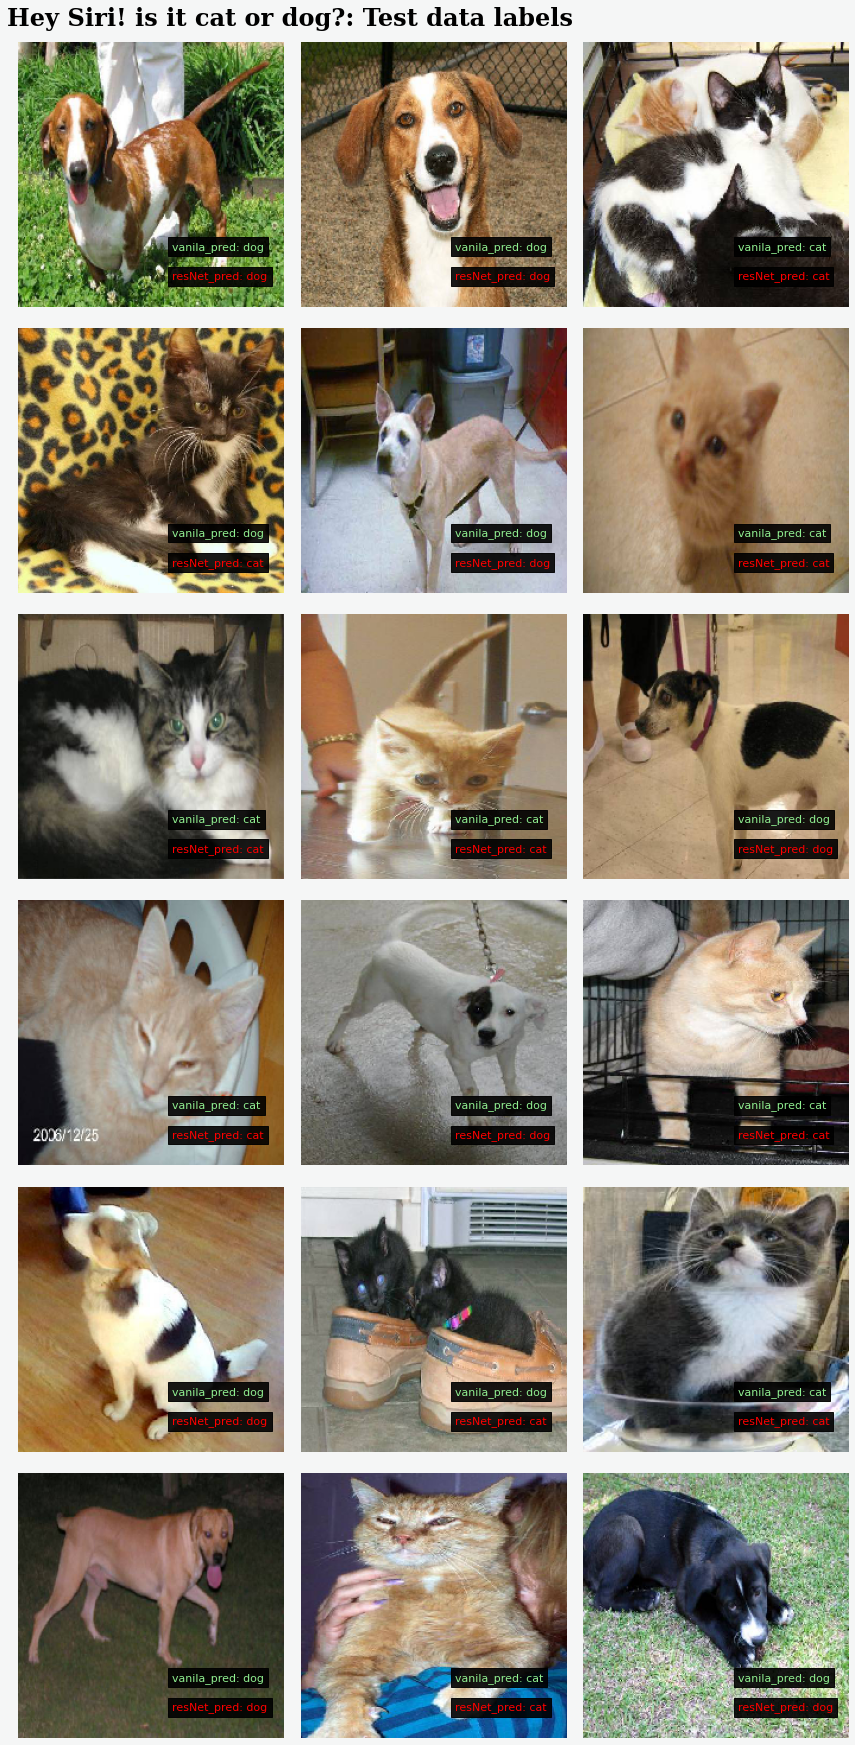

In [35]:
pred_sample = submission_image_df.sample(18)
pred_sample.reset_index(drop = True, inplace = True)

fig = plt.figure(figsize=(12,24))
fig.patch.set_facecolor('#f5f6f6')

for index, row in pred_sample.iterrows():
    filename = row['filename']
    vani_pred = row['vani_pred_sub']
    res_pred = row['res_pred_sub']
    img = load_img( test_dir + filename, target_size= (img_size, img_size))
    plt.subplot(6,3, index+1)
    plt.imshow(img)
    plt.gca().axis('off')
    plt.text(130, 175, 'vanila_pred: {}'.format(vani_pred), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(130, 200, 'resNet_pred: {}'.format(res_pred), color='red',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    #plt.title(filename.split('.')[0])
    del img
plt.tight_layout()
#plt.subplots_adjust( wspace=0, hspace= 1)
fig.text(0,1, 'Hey Siri! is it cat or dog?: Test data labels',{'fontfamily':'serif','size':24,'weight':'bold'})
fig.show()
   

<a id = '8.0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color:#FFCE30 ; color : #36609A; border-radius: 5px 5px; padding:3px;text-align:center; font-weight: bold" >8. Summary</h2> 

<p style = "font-size: 30px; font-style: normal;color : #36609A;font-weight:bold" >What happened so far?</p>

So far, I have tried to build a cat and dog classifier with help of deeplearning models, lets see the steps 
<ol>
    <li>Data processing and visualization</li>
    <li>Build a basic CNN and make prections</li>
    <li>Explored Data Agumentation and Learning rate Schedule</li>
    <li>Build a Resnet based Transfer leraning model and make prections</li>
    <li>final comparision of both models results</li>
</ol>

<p style = "font-size: 30px; font-style: normal;color : #36609A;font-weight:bold" >Thank you so much for reading all the way here.....Hope you enjoyed my work.....!!! I am open to suggetions. Please do comment if you any advice or critical comments... Thanks again!!!</p>